# Strain map of a transistor

The `libertem_blobfinder.udf`, `libertem_blobfinder.common.gridmatching` and `libertem_blobfinder.common.fullmatch` modules of LiberTEM-blobfinder allow to find and trace the position of CBED diffraction disks, and to derive grid parameters. These grid parameters can be used to determine lattice strain.

The sample is a dummy transistor with a SiN gate and recessed SiGe source/drain. The SiGe source/drain are used to introduce a compression of the Si channel. 

Sample data: Thibaud Denneulin, ER-C Forschungszentrum Jülich

In [1]:
%matplotlib inline

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
from matplotlib import cm

In [3]:
import libertem.api as lt
from libertem.udf import logsum
# fullmatch requires hdbscan, which is an optional dependency
import libertem_blobfinder.common.fullmatch as fm
import libertem_blobfinder.base.masks as masks
from libertem_blobfinder.base.utils import make_polar

from libertem_blobfinder.common import patterns, correlation
from libertem_blobfinder.udf import refinement, utils

Using a descriptor dictionary allows to implement batch processing of many files more easily.

In [4]:
data_base_path = os.environ.get("TESTDATA_BASE_PATH", "/home/alex/Data/")

In [5]:
descriptors = [
    {'path': os.path.join(data_base_path, 'K2IS/Thibaud_2018-10-26_SiGe-transistor/Capture93_.gtg'), 'r': 80.0},
]

In [6]:
ctx = lt.Context()

/Users/weber/.conda/envs/lt311/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33196 instead
  warnings.warn(


## Opening files and determining basic parameters

In [7]:
for d in descriptors:
    d['dirname'] = os.path.dirname(os.path.abspath(d['path']))
    d['base'], _ = os.path.splitext(os.path.basename(d['path']))
    d['ds'] = ctx.load('auto', path=d['path'])
    d['y'], d['x'] = d['ds'].shape.nav
    d['fy'], d['fx'] = d['ds'].shape.sig

## Logsum frame

We calculate the sum of all log-scaled frames to generate a good overview map. This highlights peaks that are realtively weak, but present on many frames.

In [8]:
for d in descriptors:
    print("Logsum of ", d['path'])
    # Sum of log-scaled frames, which highlights weak peaks that are present in many frames
    d['logsum'] = logsum.run_logsum(ctx, d['ds'])['logsum'].data

Logsum of  /storage/er-c-data/adhoc/libertem/libertem-test-data/K2IS/Thibaud_2018-10-26_SiGe-transistor/Capture93_.gtg


## Determine base lattice
The `fullmatch` module allows to guess grid parameters to match peak positions with a parallelogram lattice.

In [9]:
matcher = fm.FullMatcher(tolerance=7)

for d in descriptors:
    try:
        print("Matching ", d['path'])
        match_pattern = patterns.BackgroundSubtraction(
            radius=d['r'], search=d['r']*1.2, radius_outer=d['r']*1.2
        )

        # Find peaks in the logsum frame
        d['found_peaks'] = correlation.get_peaks(sum_result=d['logsum'], match_pattern=match_pattern, num_peaks=d.get('num_disks', 20))
        # Find lattice match for peaks from scratch
        # This doesn't take into account the 3D crystal structure of the sample,
        # but works purely within the 2D geometry of the detector
        (d['matches'], d['unmatched'], d['weak']) = matcher.full_match(d['found_peaks'])
    except Exception as e:
        print(repr(e))

Matching  /storage/er-c-data/adhoc/libertem/libertem-test-data/K2IS/Thibaud_2018-10-26_SiGe-transistor/Capture93_.gtg


In this case, the zero order peak was not the most intense peak. For that reason we patch the result by shifting it and ajusting the indices.

In [10]:
for d in descriptors:
    m = d['matches'][0]
    m.zero += m.a
    m.indices[:, 0] -= 1
    m.zero -= m.b
    m.indices[:, 1] += 1

We visualize the logsum frame, the peaks and the match.

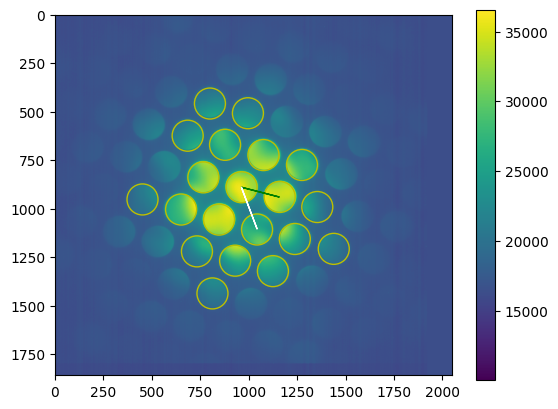

In [11]:
for d in descriptors:
    try:
        # Visualize found peaks and lattice match
        fig, axes = plt.subplots()
        pcm = axes.imshow(d['logsum'])

        fig.colorbar(pcm, ax=axes)

        
        for p in np.flip(d['found_peaks'], axis=1):
            axes.add_artist(plt.Circle(p, d['r'], color="y", fill=False))


        axes.arrow(*np.flip(m.zero), *(np.flip(m.a)), color='g')
        axes.arrow(*np.flip(m.zero), *(np.flip(m.b)), color='w')

#         fig.savefig(d['dirname'] + '/%s-logsum_frame.svg' % d['base'])
    except Exception as e:
        print(e)

We earmark a frame to serve as a reference for fine-adjustment of the template

In [12]:
descriptors[0]['ref_y'] = 17
descriptors[0]['ref_x'] = 49

## Adjust matching template
The data was recorded at fairly high detector resolution and the bright field disk is slightly distorted. In order to get the optimal fit quality, the template is tuned by hand to match the CBED disk as precisely as possible. We use a combination of radial gradient and background subtraction to match the edge of the CBED disks with maximum contrast while ignoring structure within the CBED disks.

See also https://github.com/LiberTEM/LiberTEM/issues/395

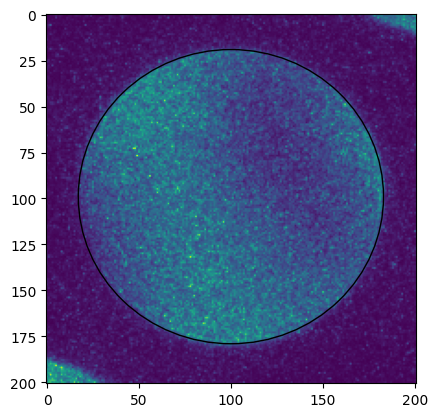

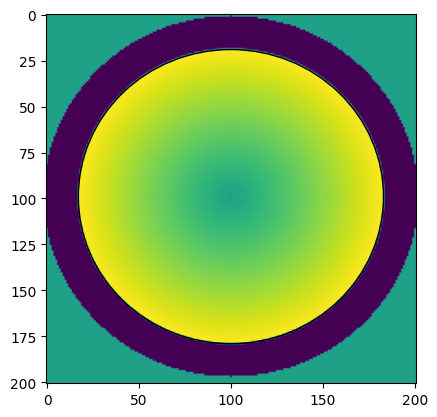

In [13]:
for d in descriptors:
    pick_a = ctx.create_pick_analysis(dataset=d['ds'], y=d['ref_y'], x=d['ref_x'])
    res = ctx.run(pick_a)
    cy, cx = np.round(d['matches'][0].zero).astype(int)
    rr = int(np.ceil(d['r']))
    sample = res.intensity.raw_data[cy-rr-20:cy+rr+21, cx-rr-20:cx+rr+21]
    fig, axes = plt.subplots()
    axes.imshow(sample)
    p = ptch.Ellipse((rr+20, rr+19), width=2*rr+6, height=2*rr, angle=0, fill=False)
    axes.add_patch(p)
    
    radius, phi = masks.polar_map(
        centerX=rr+20, centerY=rr+19, imageSizeX=sample.shape[1], imageSizeY=sample.shape[0],
        stretchY=(2*rr + 6)/(2*rr),
        angle=np.pi/2
    )
    template = masks.radial_gradient_background_subtraction(
        r=radius,
        r0=d['r'],
        r_outer=rr+18,
    )
    template = masks.balance(template)
    fig, axes = plt.subplots()
    axes.imshow(template)
    p = ptch.Ellipse((rr+20, rr+19), width=2*rr+6, height=2*rr, angle=0, fill=False)
    axes.add_patch(p)
    d['template'] = template


We compare the shape over a number of frames from different positions in the scan. Note how the CBED disk has slightly varying shape. https://github.com/LiberTEM/LiberTEM/issues/395

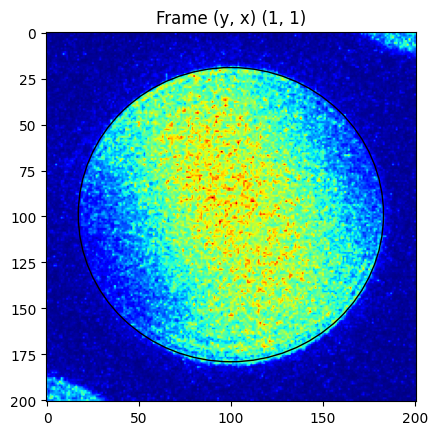

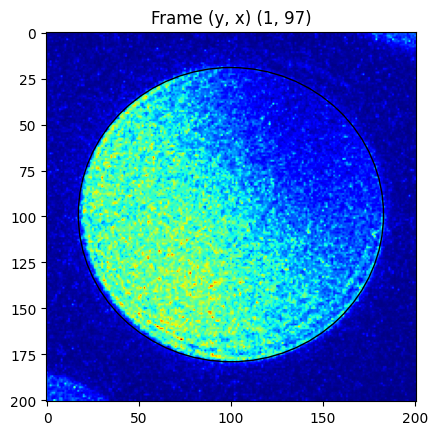

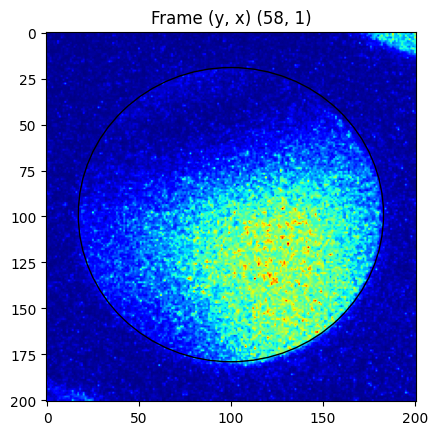

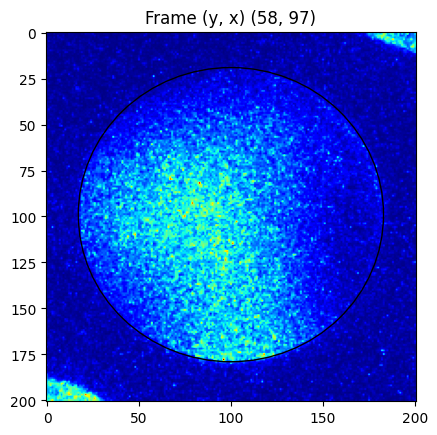

In [14]:
for d in descriptors:
    for coords in [(1, 1), (1, d['x']-2), (d['y']-2, 1), (d['y']-2, d['x']-2)]:
        y, x = coords
        pick_a = ctx.create_pick_analysis(dataset=d['ds'], y=y, x=x)
        res = ctx.run(pick_a)
        cy, cx = np.round(d['matches'][0].zero).astype(int)
        rr = int(np.ceil(d['r']))
        sample = res.intensity.raw_data[cy-rr-20:cy+rr+21, cx-rr-20:cx+rr+21]
        fig, axes = plt.subplots()
        axes.imshow(sample, cmap=cm.jet)
        p = ptch.Ellipse((rr+20, rr+19), width=2*rr+6, height=2*rr, angle=0, fill=False)
        axes.add_patch(p)
        plt.title("Frame (y, x) %s" % str(coords))

## Refine the lattice

Now we refine the lattice parameters for each frame using our custom template.

In [15]:
matcher.min_weight = 1

for d in descriptors:
    custom_pattern = patterns.UserTemplate(template=d['template'])
    print("Refining ", d['path'])
    m = d['matches'][0]
    # Refine the lattice parameters for each frame
    d['match'], d['indices'] = refinement.run_refine(
        ctx=ctx,
        dataset=d['ds'],
        zero=m.zero,
        a=m.a,
        b=m.b,
        indices=np.mgrid[-3:4, -3:4],
        matcher=matcher,
        match_pattern=custom_pattern,
        progress=True,
    )

Refining  /storage/er-c-data/adhoc/libertem/libertem-test-data/K2IS/Thibaud_2018-10-26_SiGe-transistor/Capture93_.gtg


Partitions 0/168, Frames:   0%|          | 0/5940 [00:00<?, ?it/s]

## Post-processing and visualization

We set some markers and parameters for subsequent batch-oriented visualizations.

In [16]:
descriptors[0].update({    
    'markers': [
        {'label': 'A', 'y': 8, 'x': 16},
        {'label': 'B', 'y': 8, 'x': 90},
        {'label': 'C', 'y': 4, 'x': 50},
        {'label': 'D', 'y': 50, 'x': 50},
    ],
    'comparison': {'y1': 8, 'x1': 16, 'y2': 50,'x2': 50},
})

We do some postprocessing, most importantly converting to polar coordinates. The polar versions of the vectors are pairs of (length, angle) that make it easier to calculate size ratios and rotations or angle differences.

In [17]:
for d in descriptors:
    match = d['match']
    d['zeros'] = match['zero'].data
    d['aas'] = match['a'].data
    d['bbs'] = match['b'].data
    d['polar_zeros'] = make_polar(match['zero'].data)
    d['polar_aas'] = make_polar(match['a'].data)
    d['polar_bbs'] = make_polar(match['b'].data)

In [18]:
def mark(axes, markers):
    for m in markers:
        axes.text(
            m['x'], m['y'], m['label'], 
            bbox={'boxstyle': 'circle', 'fc': (1, 1, 1, 0.5)},
            ha="center",
            va="center"
        )

This is an overview frame with the marker positions

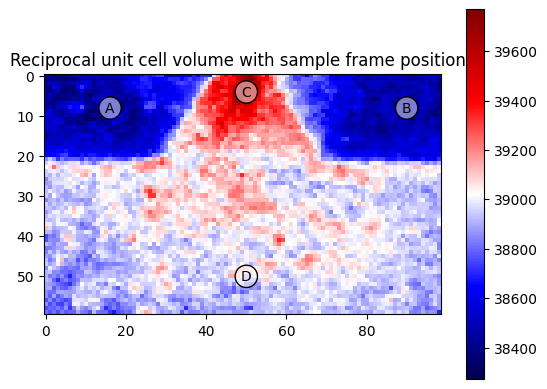

In [19]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(
        d['polar_aas'][:, :, 0] *\
        d['polar_bbs'][:, :, 0] *\
        np.abs(np.sin(d['polar_aas'][:, :, 1] - d['polar_bbs'][:, :, 1])),
        cmap=cm.seismic,
    )
    if 'markers' in d:
        mark(axes, d['markers'])

    fig.colorbar(pcm, ax=axes)
    plt.title("Reciprocal unit cell volume with sample frame positions")

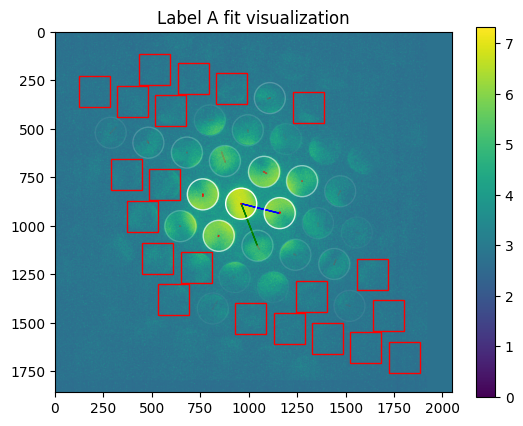

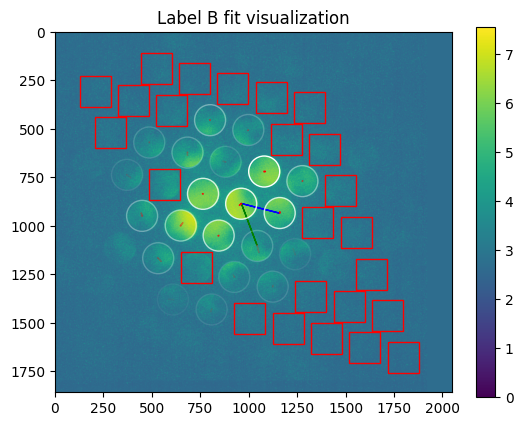

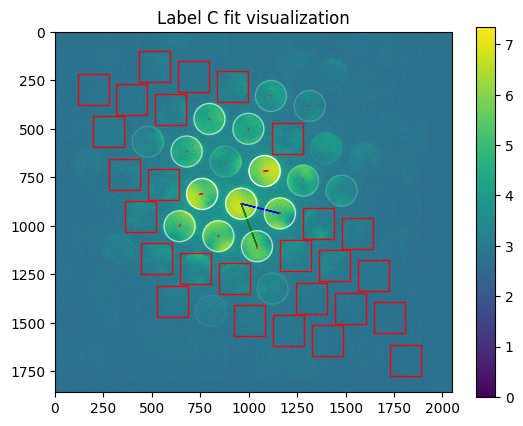

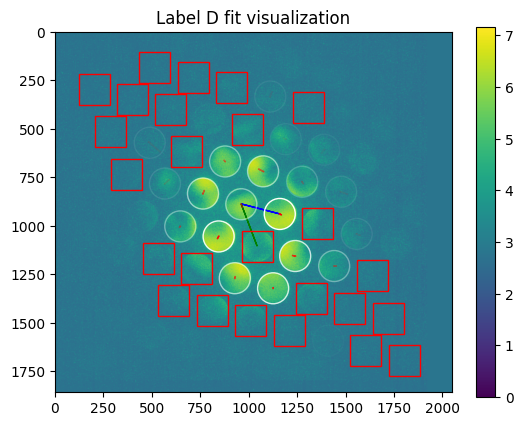

In [20]:
for d in descriptors:
    if 'markers' in d:
        for m in d['markers']:
            # Visualize the refinement of a specific frame
            fig, axes = plt.subplots()

            pcm = utils.visualize_frame(
                ctx, d['ds'],
                result=d['match'],
                indices=d['indices'],
                r=d['r'],
                y=m['y'],
                x=m['x'],
                axes=axes
            )

            fig.colorbar(pcm, ax=axes)
            plt.title("Label %s fit visualization" % m['label'])

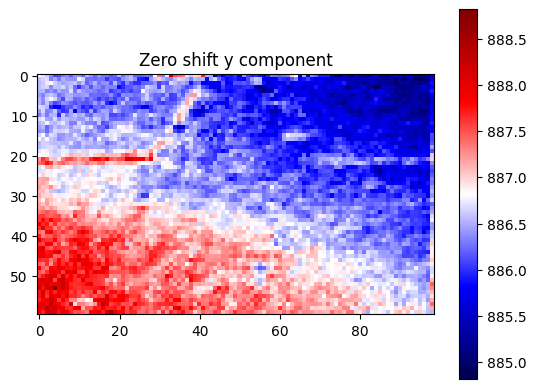

In [21]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(d['zeros'][:, :, 0], cmap=cm.seismic)
    fig.colorbar(pcm, ax=axes)
    plt.title("Zero shift y component")

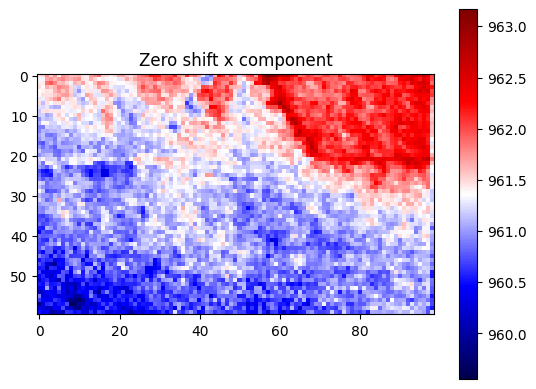

In [22]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(d['zeros'][:, :, 1], cmap=cm.seismic)
    fig.colorbar(pcm, ax=axes)
    plt.title("Zero shift x component")

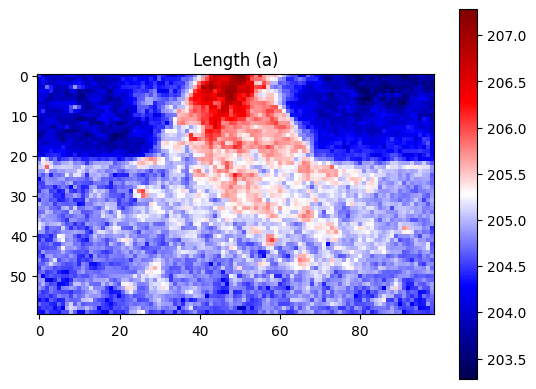

In [23]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(d['polar_aas'][:, :, 0], cmap=cm.seismic)
    fig.colorbar(pcm, ax=axes)
    plt.title("Length (a)")

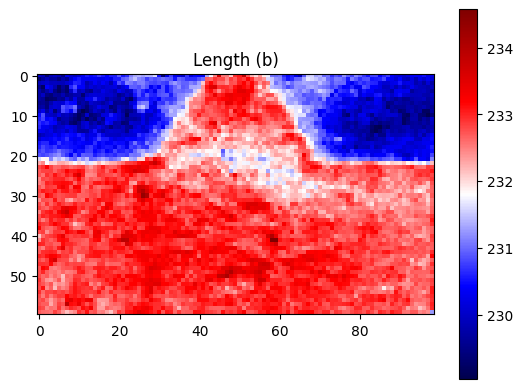

In [24]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(d['polar_bbs'][:, :, 0], cmap=cm.seismic)
    fig.colorbar(pcm, ax=axes)
    plt.title("Length (b)")

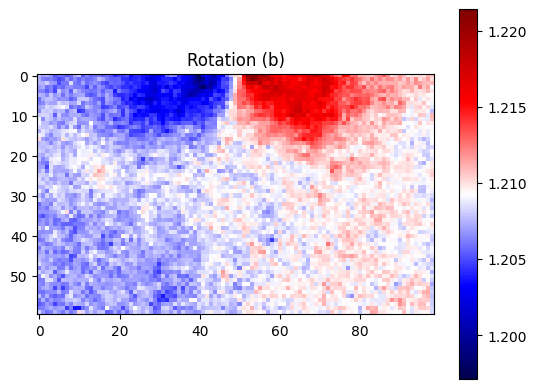

In [25]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(d['polar_bbs'][:, :, 1], cmap=cm.seismic)
    fig.colorbar(pcm, ax=axes)
    plt.title("Rotation (b)")

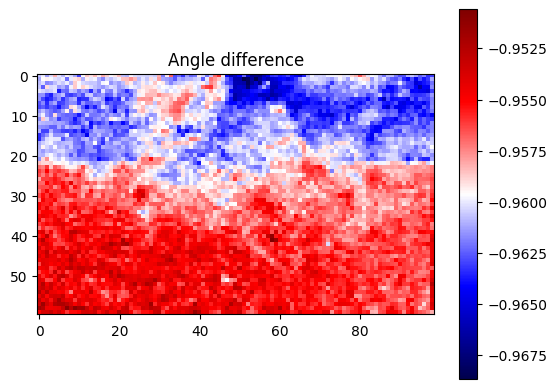

In [26]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(d['polar_aas'][:, :, 1] - d['polar_bbs'][:, :, 1], cmap=cm.seismic)
    fig.colorbar(pcm, ax=axes)
    plt.title("Angle difference")

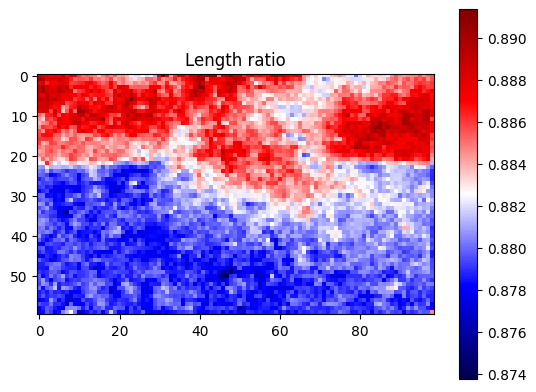

In [27]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(d['polar_aas'][:, :, 0] / d['polar_bbs'][:, :, 0], cmap=cm.seismic)
    fig.colorbar(pcm, ax=axes)
    plt.title("Length ratio")

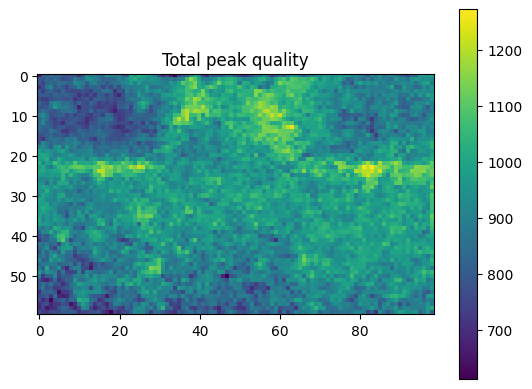

In [28]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(
        d['match']['peak_elevations'].data.sum(axis=-1)
    )
    fig.colorbar(pcm, ax=axes)
    plt.title("Total peak quality")

Note how the fitting error is larger in the lower left corner where the CBED disk shape differs slightly from the template as shown above.

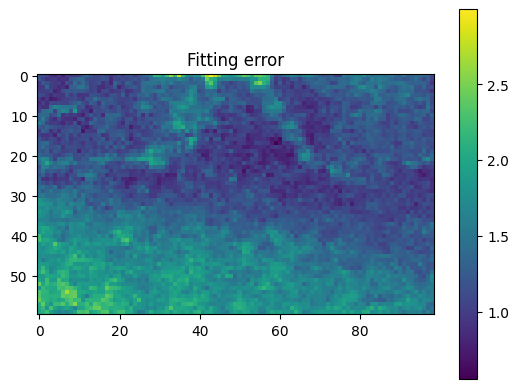

In [29]:
for d in descriptors:
    fig, axes = plt.subplots()
    pcm = axes.imshow(match['error'].data)
    fig.colorbar(pcm, ax=axes)
    plt.title("Fitting error")